추가적인 코디정보를 크롤링하기 위해서 만들어진 주피터 노트북입니다.

In [2]:
import os
import pickle

import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By

from tqdm import tqdm
from typing import Tuple

# pip install openpyxl
from openpyxl import Workbook
from openpyxl.worksheet.worksheet import Worksheet

In [13]:
codi_df = pd.read_csv('/opt/ml/input/data/asset_codishop/view/codi/codi.csv')
codi_df

,id,style,img_url,url,popularity
0,11748,스트릿,https://image.msscdn.net/images/style/list/l_3...,https://www.musinsa.com/app/styles/views/11748,68162
1,4709,캐주얼,https://image.msscdn.net/images/codimap/detail...,https://www.musinsa.com/app/codimap/views/4709,4815
2,13912,캐주얼,https://image.msscdn.net/images/codimap/detail...,https://www.musinsa.com/app/codimap/views/13912,2377
3,26049,스트릿,https://image.msscdn.net/images/style/detail/2...,https://www.musinsa.com/app/styles/views/26049,1383
4,25609,캐주얼,https://image.msscdn.net/images/style/detail/2...,https://www.musinsa.com/app/styles/views/25609,5436
...,...,...,...,...,...
329,18298,캐주얼,https://image.msscdn.net/images/style/detail/1...,https://www.musinsa.com/app/styles/views/18298,4123
330,18355,스트릿,https://image.msscdn.net/images/style/detail/1...,https://www.musinsa.com/app/styles/views/18355,2263
331,18423,캐주얼,https://image.msscdn.net/images/style/detail/1...,https://www.musinsa.com/app/styles/views/18423,1801
332,13104,캐주얼,https://image.msscdn.net/images/style/detail/1...,https://www.musinsa.com/app/styles/views/13104,1957


In [14]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument(argument='--headless')
chrome_options.add_argument(argument='--no-sandbox')
chrome_options.add_argument(argument='--disable-dev-shm-usage')

driver = webdriver.Chrome(executable_path='chromedriver', options=chrome_options)
driver.implicitly_wait(1.5)

In [27]:
img_url_list = list()

for idx, data in tqdm(codi_df.iterrows(), total=len(codi_df)):
    codi_id = data['id']
    codi_url = data['url']

    # 코디의 정보가 있는 페이지로 접속한다.
    # 하지만, 이 코디 이미지들 중 어떤 것들이 best 샷인지 모르기 때문에 다른 아이템으로 이동한다.
    driver.get(codi_url)
    item_in_codi = driver.find_elements(by=By.CSS_SELECTOR, value=".styling_list > .swiper-slide > .box-img > .styling_img")
    if len(item_in_codi) == 0:
        print (f"현재 코디 ID {codi_id} 에는 연결된 아이템의 정보가 존재하지 않습니다.. url={codi_url}")
        img_url_list.append(data['img_url'])
        continue
    item_in_codi_url = item_in_codi[0].get_attribute('href')

    #  아이템에 포함된 코디의 정보들을 가져온다.
    driver.get(item_in_codi_url)
    codi_in_item = driver.find_elements(by=By.CSS_SELECTOR, value='.style_list > .list_item > .img-block')
    codi_img_in_item = driver.find_elements(by=By.CSS_SELECTOR, value='.style_list > .list_item > .img-block > .coordi_img')

    for codi_url_tag, codi_img_url_tag in zip(codi_in_item, codi_img_in_item):
        current_id = codi_url_tag.get_attribute('href').split("/")[-1]
        if str(current_id) == str(codi_id):
            current_img_url = codi_img_url_tag.get_attribute('src')
            img_url_list.append(current_img_url)
            # codi_df.iloc[row_idx]['img_url'] = current_img_url
            break
        
    img_url_list.append(data['img_url'])

    print (f"{idx} / {len(codi_df)} Done.")

100%|██████████| 334/334 [26:11<00:00,  4.71s/it] 


In [28]:
len(codi_df)

334

In [29]:
len(img_url_list)

328

In [ ]:
codi_df['img_url'] = img_url_list

In [21]:
codi_df.to_csv('/opt/ml/input/data/asset_codishop/view/codi/codi.csv', index=False)

In [24]:
from PIL import Image
import requests
from io import BytesIO

from IPython.display import clear_output
# 이미지를 불러오는 함수
def get_img_from_url(url: str) -> Image:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

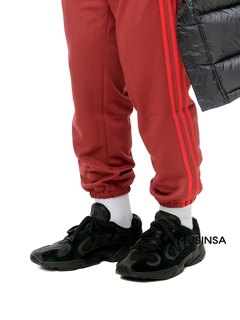

KeyboardInterrupt: Interrupted by user

In [25]:
for img_url in codi_df['img_url']:
    try:
        img = get_img_from_url(img_url)
    except:
        print (f"[Exception] Failed to load image url = {img_url}", flush=True)
        continue
    
    img = img.resize((240, 320))
    display(img)

    correction = str(input())
    clear_output(wait=True)

In [ ]:
for codi_url in tqdm(new_codi_url['rel_codi_url']):
    codi_id = codi_url.split("/")[-1]
    driver.get(codi_url)

    codi_style = driver.find_element(by=By.CSS_SELECTOR, value=".style-title-box > .title").text
    
    is_codimap = driver.find_element(by=By.CSS_SELECTOR, value='.title_box > .title-page').text
    if is_codimap == "Codimap":
        codi_img_url = driver.find_elements(by=By.CSS_SELECTOR, value=".codimap-cont > .photo")
        codi_img_url = codi_img_url[-1].get_attribute('src')
    else:
        codi_img_url = driver.find_elements(by=By.CSS_SELECTOR, value=".detail_img")
        codi_img_url = codi_img_url[-1].get_attribute('src')
    # print (codi_img_url)
    
    codi_popularity = driver.find_element(by=By.CSS_SELECTOR, value=".styling_date > #view_num").text
    codi_popularity = codi_popularity.split(" ")[-1]

    codi_tags = driver.find_elements(by=By.CSS_SELECTOR, value=".styling_tag > .ui-tag-list > a")
    codi_tag_list = list()
    for codi_tag_anchor in codi_tags:
        codi_tag_list.append(codi_tag_anchor.text)

    for tag in codi_tag_list:
        codi_tag_len = len(prev_tag_df)
        prev_tag_df.loc[codi_tag_len] = [codi_id, tag]


    # print ("codi_id", codi_id)
    # print ("codi style", codi_style)
    # print ("codi img url", codi_img_url)
    # print ("codi popularity", codi_popularity)
    # print ("codi tags", codi_tag_list)

    codi_df_len = len(prev_codi_df)
    prev_codi_df.loc[codi_df_len] = [codi_id, codi_style, codi_img_url, codi_url, codi_popularity]

    # break

In [ ]:
prev_codi_df['popularity'] = prev_codi_df['popularity'].apply(lambda x : int(str(x).replace(",", "")))

In [ ]:
prev_codi_df.astype({
    'id': 'int',
    'popularity': 'int'
})

prev_tag_df.astype({
    'id': 'int',
})

In [ ]:
prev_codi_df.to_excel("/opt/ml/input/data/raw_codishop/view/codi/codi.xlsx", index=False)
prev_tag_df.to_excel("/opt/ml/input/data/raw_codishop/view/codi/codi_tag.xlsx", index=False)

In [ ]:
driver.close()